Libraries

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from scipy.optimize import minimize
import quantstats as qs
import matplotlib.pyplot as plt
from fredapi import Fred

In [16]:
#IRX - TBills, AGZ- Agency Securities, TFLO - Treasury Floating Rate
#repos - 39.8%, us treasury securities - 21.2%, us government agency securities 19.6%,
# floating rate securities - 19%, other assets - 0.3%
fred = Fred(api_key = 'bb2f36e64e42974f650054bf95915c16')
#Is Forward Fill acceptable?
repo_data = fred.get_series('SOFR', observation_start='2018-04-03').fillna(method='ffill')

assets = ['^IRX', 'AGZ', 'TFLO']
START = dt.date(2018,4,3)
END = dt.date.today() + dt.timedelta(days=1)
asset_df = yf.download(assets, start=START, end=END,progress=False)
returns = asset_df['Adj Close'].pct_change()


/var/folders/lf/j0v682ps7wng8lvvdw8kt_nw0000gn/T/ipykernel_76515/1404731841.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  repo_data = fred.get_series('SOFR', observation_start='2018-04-03').fillna(method='ffill')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-package

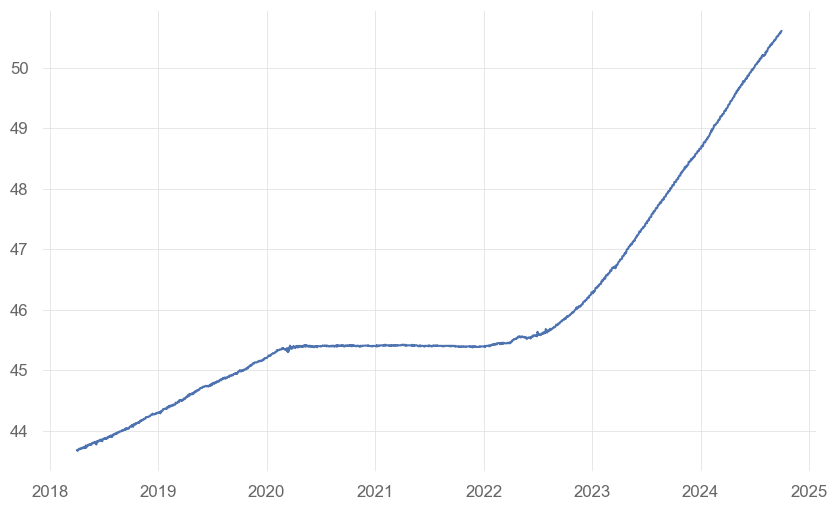

In [17]:
plt.figure
plt.plot(asset_df['Adj Close']['TFLO'])
plt.show()

In [18]:
returns

,AGZ,TFLO,^IRX
Date,,,
2018-04-03,NaN,NaN,NaN
2018-04-04,0.001076,0.000199,-0.026270
2018-04-05,-0.002508,-0.000398,0.004197
2018-04-06,0.002065,0.000199,0.002985
2018-04-09,-0.000090,0.000398,-0.002976
...,...,...,...
2024-09-24,0.000995,0.000198,-0.001777
2024-09-25,-0.001626,0.000198,-0.001780
2024-09-26,0.000000,-0.000198,-0.004234


In [19]:
repo = pd.DataFrame(repo_data).reset_index()
repo.columns = ['datetime', 'Annualized Returns']
repo['datetime'] = pd.to_datetime(repo['datetime'])
repo = repo.set_index('datetime')
repo.head()

,Annualized Returns
datetime,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [20]:
'''
specify simple or compounded
'''
def annual_to_daily(df, trading_days=365, type='compounded'):
    if type == 'compounded':
        df['Daily Returns'] = (1 + df['Annualized Returns'] / 100) ** (1/trading_days) - 1
    elif type =='simple':
        df['Daily Returns'] = (1 + df['Annualized Returns'] / 100) / trading_days
    else:
        raise ValueError("Type not found")
        
    return df

In [21]:
repo = annual_to_daily(repo, type='compounded')
returns.insert(3, 'Repo Daily Returns', repo['Daily Returns'])

In [22]:
returns = returns.dropna()
returns

,AGZ,TFLO,^IRX,Repo Daily Returns
Date,,,,
2018-04-04,0.001076,0.000199,-0.026270,0.000047
2018-04-05,-0.002508,-0.000398,0.004197,0.000048
2018-04-06,0.002065,0.000199,0.002985,0.000048
2018-04-09,-0.000090,0.000398,-0.002976,0.000048
2018-04-10,-0.000896,0.000199,0.011940,0.000048
...,...,...,...,...
2024-09-23,0.000271,0.000198,-0.009241,0.000129
2024-09-24,0.000995,0.000198,-0.001777,0.000130
2024-09-25,-0.001626,0.000198,-0.001780,0.000130


In [23]:
def get_mean_variance_weights(returns):
    
    
    def portfolio_volatility(weights, mean_returns, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_weights = num_assets * [1. / num_assets,]

    result = minimize(portfolio_volatility, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

mvo_weights = get_mean_variance_weights(returns)
mvo_weights = pd.Series(mvo_weights, index= ['AGZ', 'TFLO','^IRX', 'Repo Daily Returns'])
equal_weights = pd.Series(1 / (returns.shape[1]),index = ['AGZ', 'TFLO','^IRX', 'Repo Daily Returns'])
nuveen_weights = pd.Series([0.2,0.2,0.2, 0.4], index = ['AGZ', 'TFLO','^IRX', 'Repo Daily Returns'])

In [32]:
'''
Finding MVO weights using cvxpy
'''
import cvxpy as cp
weights = cp.Variable(returns.shape[1])
mu = returns.mean().values
cov = returns.cov().values
portfolio_return = mu.T @ weights
# portfolio_volatility = cp.sqrt(cp.quad_form(weights, cov))
objective = cp.Minimize(cp.quad_form(weights, cov)) ## minimize portfolio variance

constraints = [
    cp.sum(weights) == 1,  # Weights must sum to 1
    weights >= 0  # No short selling
]

problem = cp.Problem(objective, constraints)
problem.solve()
optimal_weights = weights.value
print(pd.Series(index=returns.columns, data=optimal_weights, name='CVXPY MVO Weights'))
print(mvo_weights)

AGZ                   0.002494
TFLO                  0.400302
^IRX                  0.000033
Repo Daily Returns    0.597171
Name: CVXPY MVO Weights, dtype: float64
AGZ                   0.000000
TFLO                  0.496607
^IRX                  0.000031
Repo Daily Returns    0.503362
dtype: float64


In [35]:
# Calculate daily portfolio returns for each portfolio
equal_weighted_returns = returns.dot(equal_weights)
nuveen_weighted_returns = returns.dot(nuveen_weights)
mvo_weighted_returns = returns.dot(mvo_weights)

# Calculate cumulative returns for each portfolio
equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod() - 1
nuveen_weighted_cumulative = (1 + nuveen_weighted_returns).cumprod() - 1
mvo_weighted_cumulative = (1 + mvo_weighted_returns).cumprod() - 1

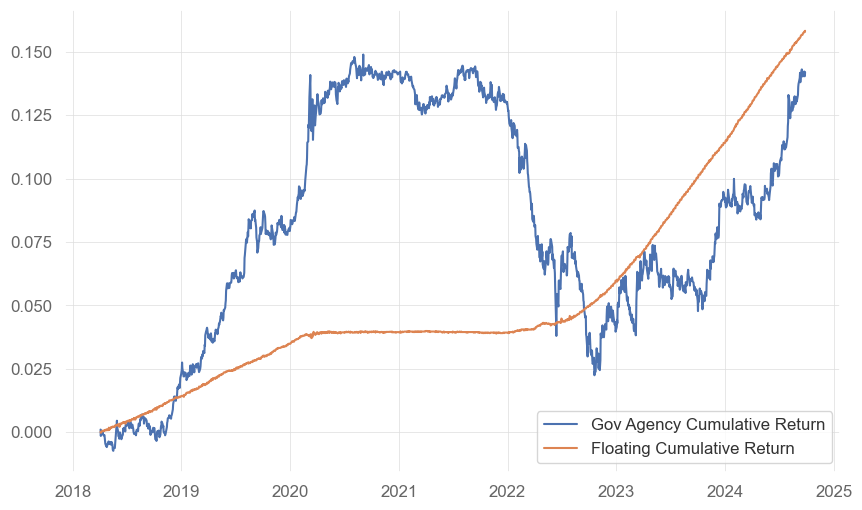

In [79]:
plt.figure()
#plt.plot((1+returns['Repo Daily Returns']).cumprod()-1, label='Repo Cumulative Return')
#plt.plot((1+asset_df['Adj Close']['^IRX'].pct_change()).cumprod()-1, label='TBill Cumulative Return')
plt.plot((1+asset_df['Adj Close']['AGZ'].pct_change()).cumprod()-1, label='Gov Agency Cumulative Return')
plt.plot((1+asset_df['Adj Close']['TFLO'].pct_change()).cumprod()-1, label='Floating Cumulative Return')

plt.legend()
plt.show()

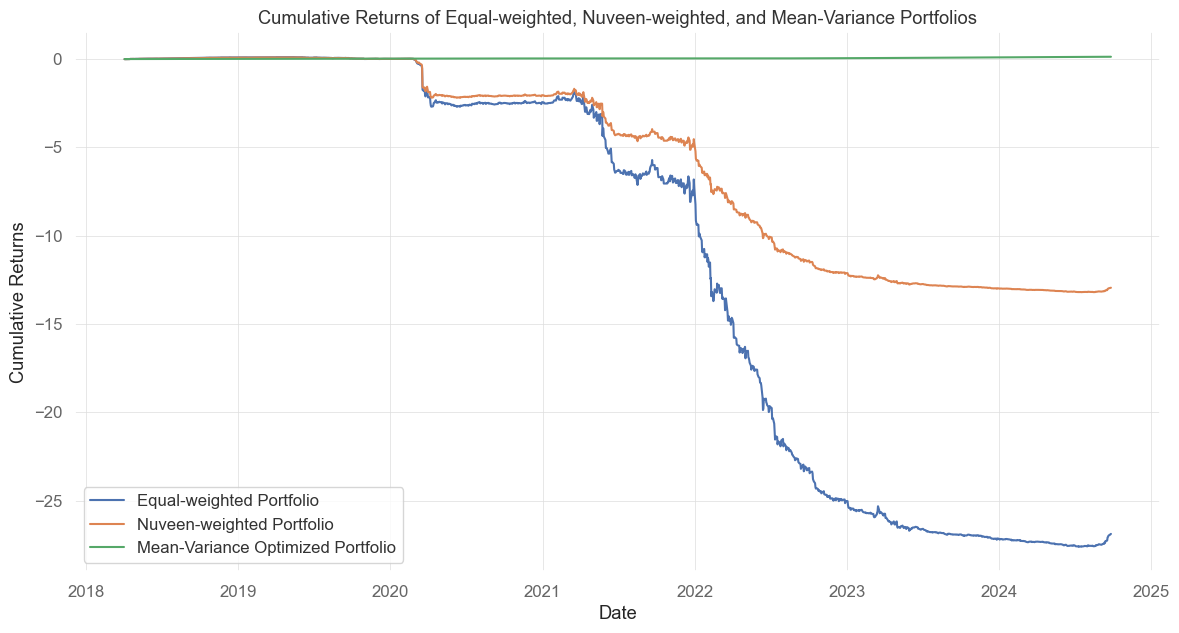

In [80]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(equal_weighted_cumulative, label='Equal-weighted Portfolio')
plt.plot(nuveen_weighted_cumulative, label='Nuveen-weighted Portfolio')
plt.plot(mvo_weighted_cumulative, label='Mean-Variance Optimized Portfolio')
plt.title('Cumulative Returns of Equal-weighted, Nuveen-weighted, and Mean-Variance Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()